In [2]:
## last edited: 5/27/22
## Status: Fixed path names to match new directory structure. 
##         Mostly testing out plotting IR satellite images. A really nice eye figure can be found at the bottom!
##         I was hoping to automate the creation of those types of figures but it's still a little buggy, see "satellite
##         data all tc eyes" for that script

from datetime import datetime
import os

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import metpy  # noqa: F401
import numpy as np
import xarray as xr
import shapely.geometry as sgeom
import matplotlib.patches as mpatches
import warnings

os.chdir(  "/Users/etmu9498/research/code/scripts")
import make_plots

In [3]:
path = "/Users/etmu9498/research/data/goes-satellite/older"
os.chdir(path)

# for 9/29, 21:37 Mesoscale 2... looking at TC sam! focusing on TC eye pass 1 
# when aircraft is as centrally located as possible
# C = xr.open_dataset( "OR_ABI-L2-MCMIPM2-M6_G16_s20212722137553_e20212722138010_c20212722138094.nc")

# for 9/29, 22:54 Mesoscale 2... looking at centrally located eye pass 2
# C = xr.open_dataset( "OR_ABI-L2-MCMIPM2-M6_G16_s20212722254553_e20212722255021_c20212722255096.nc")

# for 9/26, 22:38 Mesoscale 1... looking at TC sam eye pass 1 
C = xr.open_dataset( "OR_ABI-L2-MCMIPM1-M6_G16_s20212692238252_e20212692238314_c20212692238398.nc")
                      

In [4]:
# look at the IR bands: one with corrections, the other original

# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : {}'.format(scan_start))
print('Scan midpoint : {}'.format(scan_mid))
print('Scan End      : {}'.format(scan_end))
print('File Created  : {}'.format(file_created))
print('Scan Duration : {:.2f} minutes'.format((scan_end-scan_start).seconds/60))

# applying a normalization filter to channel 13 to correct IR stuff!
cleanIR = C['CMI_C13'].data

# Normalize the channel between a range.
#       cleanIR = (cleanIR-minimumValue)/(maximumValue-minimumValue)
cleanIR = (cleanIR-90)/(313-90)

# Apply range limits to make sure values are between 0 and 1
cleanIR = np.clip(cleanIR, 0, 1)

# Invert colors so that cold clouds are white
cleanIR = 1 - cleanIR

# Lessen the brightness of the coldest clouds so they don't appear so bright
# when we overlay it on the true color image.
cleanIR = cleanIR/1.4

RGB_cleanIR = np.dstack([cleanIR, cleanIR, cleanIR])

print( len( cleanIR))
print( len( cleanIR[3]))

Scan Start    : 2021-09-26 22:38:25.200000
Scan midpoint : 2021-09-26 22:38:28.300000
Scan End      : 2021-09-26 22:38:31.400000
File Created  : 2021-09-26 22:38:39.800000
Scan Duration : 0.10 minutes
500
500


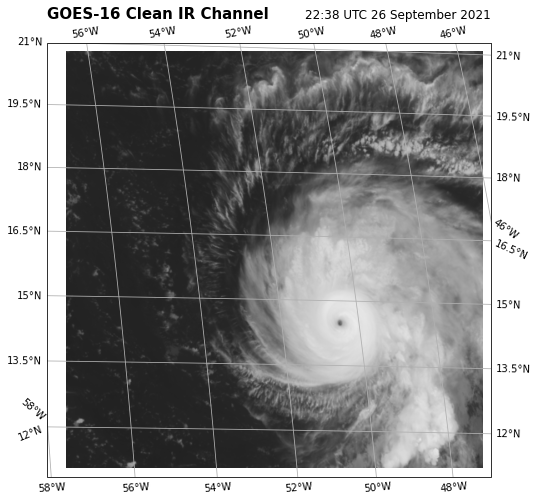

UsageError: Line magic function `%%` not found.


In [6]:
# make IR plot of full TC using cartopy
# trying to regrid geostationary projection into plate carree works really poorly :( the resolution completely dies

fig = plt.figure(figsize=(10, 8))

# these steps use goes ch 2 as a proxy to load things like lat and lon positions
dat = C.metpy.parse_cf('CMI_C02')
x = dat.x
y = dat.y
geos = dat.metpy.cartopy_crs

ax = fig.add_subplot(1, 1, 1, projection=geos) # ccrs.PlateCarree())
ax.imshow( RGB_cleanIR * 2.5, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos)

ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=1)

plt.title('GOES-16 Clean IR Channel', fontweight='bold', fontsize=15, loc='left')
plt.title('{}'.format(scan_start.strftime('%H:%M UTC %d %B %Y')),
          loc='right')

ax.gridlines(draw_labels=True)
ax.set_extent([-57, -47, 11, 21], crs=ccrs.PlateCarree())

plt.show()

%% time

In [8]:
# load crl data

crl_path = "/Users/etmu9498/research/data/CRL_data/2021"
crl_list = make_plots.load_crl( crl_path)
tdr_path = "/Users/etmu9498/research/data/tdr/sam/nc-files"
tdr_list = make_plots.load_tdr(tdr_path)

os.chdir( tdr_path)
inbound_data = tdr_list[0]
outbound_data = tdr_list[1]

os.chdir( crl_path)
crl_data = xr.open_dataset( crl_list[16])
lat = crl_data.Lat[220: 1510]# [200:1600]
lon = crl_data.Lon[220: 1510] 

dat = C.metpy.parse_cf('CMI_C02')
geos = dat.metpy.cartopy_crs
geos

# print( max( lat))
# print( min( lat))


crl data files:
0) P3_20210811H1_200000-224759.cdf
1) P3_20210812H1_095513-125927.cdf
2) P3_20210812H2_212248-235510.cdf
3) P3_20210813H1_091801-113558.cdf
4) P3_20210816H1_085245-123459.cdf
5) P3_20210816H1_090000-102359.cdf
6) P3_20210817H1_094204-132058.cdf
7) P3_20210818H1_211425-244159.cdf
8) P3_20210819H1_213003-244159.cdf
9) P3_20210820H1_212402-245958.cdf
10) P3_20210821H2_213903-225658.cdf
11) P3_20210821H2_213903-262058.cdf
12) P3_20210827H1_203112-275220.cdf
13) P3_20210828H1_200115-221321.cdf
14) P3_20210829H1_171201-223719.cdf
15) P3_20210925H1_211201-243558.cdf
16) P3_20210926H1_220900-255058.cdf
17) P3_20210927H1_213003-253558.cdf
18) P3_20210929H2_211201-261159.cdf
tdr data files:
0) 210926H1_2237_vert_inbound.nc
1) 210926H1_2237_vert_outbound.nc
2) 210926H1_2350_vert_inbound.nc
3) 210926H1_2350_vert_outbound.nc
4) 210926H1_2457_vert_inbound.nc
5) 210926H1_2457_vert_outbound.nc
6) 210927H1_2205_vert_inbound.nc
7) 210927H1_2205_vert_outbound.nc
8) 210927H1_2320_vert_inb

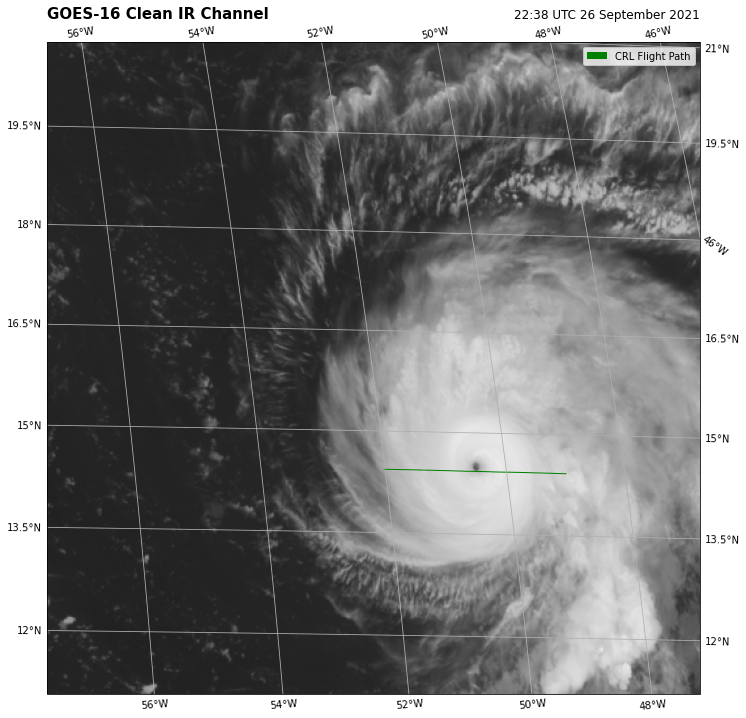

In [9]:
# Zoomed in IR plots corresponding to our data

fig = plt.figure(figsize=(15, 12))

# these steps use goes ch 2 as a proxy to load things like lat and lon positions
dat = C.metpy.parse_cf('CMI_C02')
x = dat.x
y = dat.y
geos = dat.metpy.cartopy_crs

ax = fig.add_subplot(1, 1, 1, projection=geos)

# plot crl path
track = sgeom.LineString(zip(lon, lat))
ax.add_geometries([track], ccrs.PlateCarree(),
                  facecolor='none', edgecolor='g')                          

ax.imshow( RGB_cleanIR * 2.5, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos )

sam26 = mpatches.Rectangle((0, 0), 1, 1, facecolor="g") 
ax.legend([sam26], ['CRL Flight Path'])

# ax.coastlines(resolution='50m', color='black', linewidth=1)
# ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=1)

plt.title('GOES-16 Clean IR Channel', fontweight='bold', fontsize=15, loc='left')
plt.title('{}'.format(scan_start.strftime('%H:%M UTC %d %B %Y')),
          loc='right')

# ax.tick_params(axis='both',labelsize=200,direction='out',right=False,top=False)
ax.gridlines(draw_labels=True) # , linewidth=0)

# zoom in
# ax.set_extent([-52, -49, 14.1, 14.7], crs=ccrs.PlateCarree())
# zoom out: use code snippet below or just get rid of set_extent for auto fill
# ax.set_extent([-57, -47, 11, 21], crs=ccrs.PlateCarree())

plt.show()

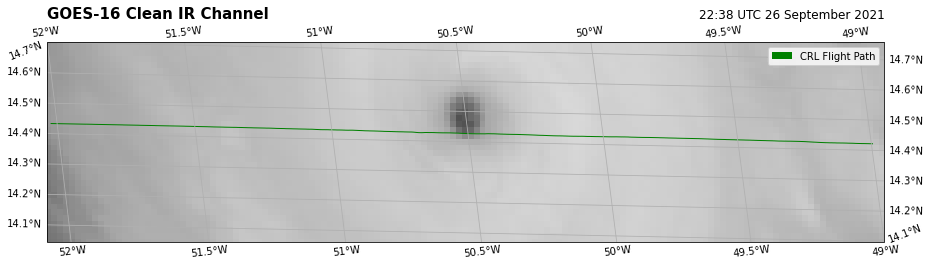

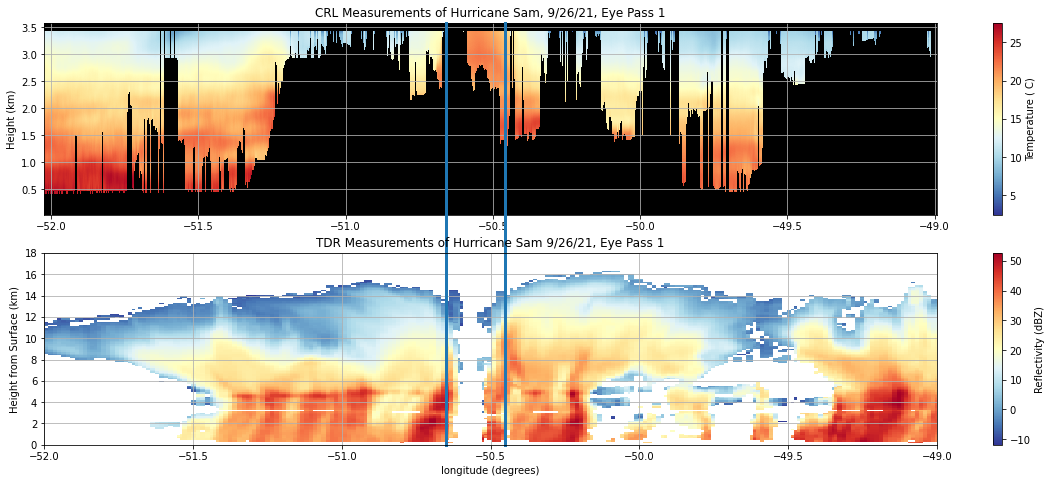

In [10]:
# sam 9/26 eye 1: 220 to 1510: this plot looks really good! I'm happy with the lat lon placements, 
# the lat line seems to go along 14.43 degrees north which is perfect

# things to fix: is there a way to change the projection so that the lat lon lines aren't slanted?!
# how to change projections? Issues with using geos and platecarree in one plot?

# change to a dashed line?


warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(15, 12))
# these steps use goes ch 2 as a proxy to load things like lat and lon positions
dat = C.metpy.parse_cf('CMI_C02')
x = dat.x
y = dat.y
geos = dat.metpy.cartopy_crs

ax = fig.add_subplot(1, 1, 1, projection=geos)

# plot crl path
track = sgeom.LineString(zip(lon, lat))
ax.add_geometries([track], ccrs.PlateCarree(),
                  facecolor='none', edgecolor='g')                          

ax.imshow( RGB_cleanIR * 2.3, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos )

sam26 = mpatches.Rectangle((0, 0), 1, 1, facecolor="g") 
ax.legend([sam26], ['CRL Flight Path'])

# ax.coastlines(resolution='50m', color='black', linewidth=1)
# ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=1)

plt.title('GOES-16 Clean IR Channel', fontweight='bold', fontsize=15, loc='left')
plt.title('{}'.format(scan_start.strftime('%H:%M UTC %d %B %Y')),
          loc='right')

ax.gridlines(draw_labels=True)
ax.set_extent([-52, -49, 14.1, 14.7], crs=ccrs.PlateCarree())
plt.show()

fig2 = plt.figure(figsize=(20, 12))

plt.subplot(312)
plt.title ("CRL Measurements of Hurricane Sam, 9/26/21, Eye Pass 1")
make_plots.plot_T( crl_path, crl_list[16], 220, 1510, 'lon')

plt.subplot(313)
plt.title( "TDR Measurements of Hurricane Sam 9/26/21, Eye Pass 1")
make_plots.plot_tdr( tdr_path, inbound_data, outbound_data, 'lon')
plt.xlim([-52, -49])

plt.axvline(x=-50.45, ymin=0, ymax=2.2, linewidth=3, clip_on=False)
plt.axvline(x=-50.65, ymin=0, ymax=2.2, linewidth=3, clip_on=False)


warnings.filterwarnings("default")


NameError: name 'RGB_cleanIR_clipped' is not defined

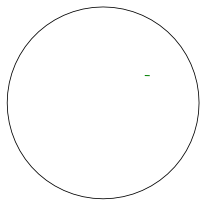

In [11]:
# the same as above but trying to fix axes and curvy lat lon lines
# actually fixing the axes is way too hard lol, it would require changing the make_plots.py script :(

warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(15, 12))
# these steps use goes ch 2 as a proxy to load things like lat and lon positions
dat = C.metpy.parse_cf('CMI_C02')
x = dat.x
y = dat.y
geos = dat.metpy.cartopy_crs

ax1 = fig.add_subplot(3, 1, 1, projection=geos)

# plot crl path
track = sgeom.LineString(zip(lon, lat))
ax1.add_geometries([track], ccrs.PlateCarree(),
                  facecolor='none', edgecolor='g')                          

RGB_cleanIR_clipped = 

ax1.imshow( RGB_cleanIR_clipped, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos )

sam26 = mpatches.Rectangle((0, 0), 1, 1, facecolor="g") 
ax1.legend([sam26], ['CRL Flight Path'])

plt.title('GOES-16 Clean IR Channel', fontweight='bold', fontsize=15, loc='left')
plt.title('{}'.format(scan_start.strftime('%H:%M UTC %d %B %Y')),
          loc='right')

ax1.gridlines(draw_labels=True)
ax1.set_extent([-52, -49, 14.1, 14.7], crs=ccrs.PlateCarree())
plt.show()

fig2 = plt.figure(figsize=(20, 12))

plt.subplot(312)
plt.title ("CRL Measurements of Hurricane Sam, 9/26/21, Eye Pass 1")
make_plots.plot_T( crl_path, crl_list[16], 220, 1510, 'lon')

plt.subplot(313)
plt.title( "TDR Measurements of Hurricane Sam 9/26/21, Eye Pass 1")
make_plots.plot_tdr( tdr_path, inbound_data, outbound_data, 'lon')
plt.xlim([-52, -49])

warnings.filterwarnings("default")
